# **Chinese Characters Recognition**

**objective:** classification of handwritten Chinese characters representing numbers

**Data set:** "Handwritten Chinese Numbers" - https://www.kaggle.com/datasets/gpreda/chinese-mnist

**Data collected by:** PhD. K Nazarpour and PhD. M Chen - Newcastle University


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split

import skimage.io
import skimage.transform
import cv2

# **Exploratory data analysis:**

First, I'm loading the 'chinese_mnist.csv' file. The file represents a mapping of the image file name with the number represented by the character in the image.

In [ ]:
#Reading .csv file  - File shows pattern of image file names (input_suite_id_sample_id_code.jpg)
data = pd.read_csv('/content/drive/MyDrive/Chinese mnist/chinese_mnist.csv')
data.head(100)

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
95,17,5,10,9,九
96,17,6,10,9,九
97,17,7,10,9,九
98,17,8,10,9,九


The files are in .jpg format, size 64 x 64.

The characters in the images are centered and take up about the same amount of space in each image.


Checking the frequency of each number/character in the dataset

In [ ]:
data.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

Comparison of the number of rows in a .csv file with the number of .jpg files in the folder.

In [ ]:
# Comparison of the num of rows in .csv vs num of .jpg files
path_jpg = '/content/drive/MyDrive/Chinese mnist/data'
print( data.shape[0], ' <-- rows in .csv file')
print(len(os.listdir(path_jpg)), ' <-- .jpg files')

15000  <-- wierszy w pliku .csv
15007  <-- plików .jpg


Adding a 'file_name' column with .jpg file names

In [ ]:
# creating file names according to the pattern and adding 'file_name' column
def file_name_col(data):
    file_name = f'input_{data[0]}_{data[1]}_{data[2]}.jpg'
    return file_name

data['file_name'] = data.apply(file_name_col, axis = 1)
data.head(10)

,suite_id,sample_id,code,value,character,file_name
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg
5,1,5,10,9,九,input_1_5_10.jpg
6,1,6,10,9,九,input_1_6_10.jpg
7,1,7,10,9,九,input_1_7_10.jpg
8,1,8,10,9,九,input_1_8_10.jpg
9,1,9,10,9,九,input_1_9_10.jpg


Verifying if the filenames in the file_name column are correct using one image as an example.

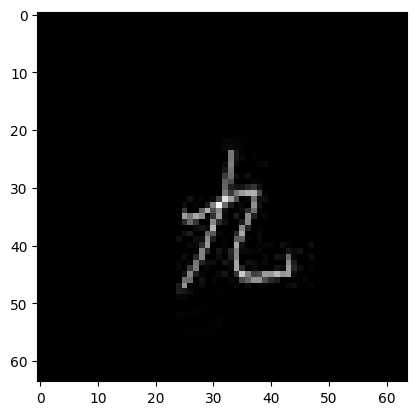

In [ ]:
# Verifying the file name
path = os.path.join(path_jpg, data['file_name'][1])
path_img = imread(path)
plt.imshow(path_img, cmap='gray')

Splitting data into training, testing and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets while maintaining class proportions in the subsets
train, test = train_test_split(data, test_size=0.2, random_state=0, stratify=data["code"])

# Splitting the training set into a training and a validation subset.
train_data, val_data = train_test_split(train, test_size=0.25, random_state=0, stratify=train["code"])

In [ ]:
# Additional check
print(f'{train.shape[0]}  <-- Train')
print(f'{test.shape[0]}  <-- Test')
print(f'{val_data.shape[0]}  <-- Validation')

12000  <-- Treningowy
3000  <-- Testowy
3000  <-- Walidacyjny


Checking the dimensions of images using one as an example.

In [ ]:
# Checking dimensions
img_check = cv2.imread(path)
shp = img_check.shape
print(shp)

(64, 64, 3)


The image dimensions are 64x64x3, indicating that the images have three color channels (RGB).

I need the images to be in grayscale, so I will transform them to have 1 channel (64x64x1).

Additionally, I will encode the labels.

In [ ]:
# Defining functions for image transformation and label encoding:
def read_image(file_nam):
    path = os.path.join(path_jpg, file_nam)

    image = skimage.io.imread(path)
    image = skimage.transform.resize(image, (64, 64, 1), mode='reflect')

    return image[:,:,:]

def character_encoder(dataset, var='character'):
    X = np.stack(dataset['file_name'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [ ]:
X_train, y_train = character_encoder(train)
X_val, y_val = character_encoder(val_data)
X_test, y_test = character_encoder(test)

print(X_train.shape, ",", y_train.shape)
print(X_val.shape, ",", y_val.shape)
print(X_test.shape, ",", y_test.shape)

(12000, 64, 64, 1) , (12000, 15)
(3000, 64, 64, 1) , (3000, 15)
(3000, 64, 64, 1) , (3000, 15)


# **Baseline Model**:

My baseline model will be a simple feedforward neural network consisting of:
- One Flatten layer
- Three Dense layers with ReLU activation functions
- An output layer with a softmax activation function.


In [ ]:
# Model
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 1)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.25)


Epoch 1/10
141/141 [==============================] - 8s 8ms/step - loss: 1.5753 - accuracy: 0.4899 - val_loss: 0.9647 - val_accuracy: 0.6670
Epoch 2/10
141/141 [==============================] - 1s 5ms/step - loss: 0.5556 - accuracy: 0.8078 - val_loss: 0.6128 - val_accuracy: 0.8013
Epoch 3/10
141/141 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9177 - val_loss: 0.7813 - val_accuracy: 0.7720
Epoch 4/10
141/141 [==============================] - 1s 5ms/step - loss: 0.1417 - accuracy: 0.9521 - val_loss: 0.6797 - val_accuracy: 0.8237
Epoch 5/10
141/141 [==============================] - 1s 5ms/step - loss: 0.0760 - accuracy: 0.9740 - val_loss: 0.7654 - val_accuracy: 0.8210
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 0.0660 - accuracy: 0.9793 - val_loss: 0.8050 - val_accuracy: 0.8037
Epoch 7/10
141/141 [==============================] - 1s 5ms/step - loss: 0.0591 - accuracy: 0.9820 - val_loss: 0.7676 - val_accuracy: 0.8333
Epoch 

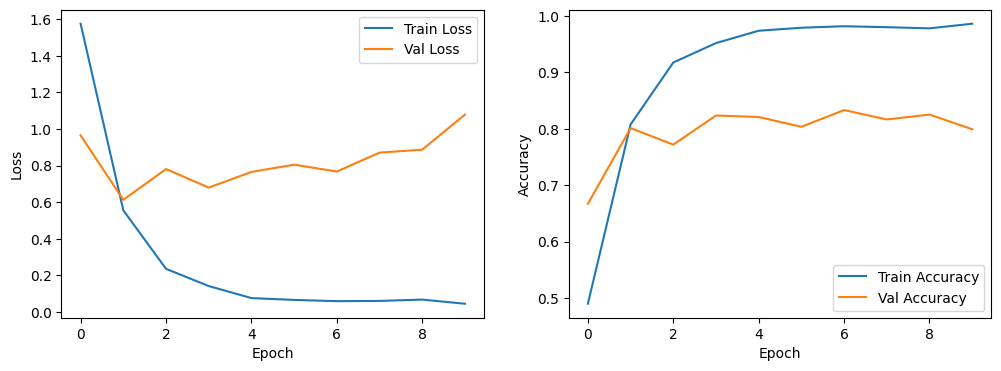

94/94 [==============================] - 0s 3ms/step - loss: 1.0382 - accuracy: 0.8033
Test Loss: 1.0382393598556519
Test Accuracy: 0.8033333420753479


In [ ]:
# Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

The charts indicate overfitting - I will add dropout to the model to improve its performance.


In [ ]:
# Model with dropout
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 1)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.25)

Epoch 1/10
141/141 [==============================] - 4s 14ms/step - loss: 2.2876 - accuracy: 0.2471 - val_loss: 1.5607 - val_accuracy: 0.5120
Epoch 2/10
141/141 [==============================] - 1s 10ms/step - loss: 1.3827 - accuracy: 0.5390 - val_loss: 1.0053 - val_accuracy: 0.6837
Epoch 3/10
141/141 [==============================] - 1s 9ms/step - loss: 0.9491 - accuracy: 0.6734 - val_loss: 0.7478 - val_accuracy: 0.7593
Epoch 4/10
141/141 [==============================] - 1s 9ms/step - loss: 0.7012 - accuracy: 0.7553 - val_loss: 0.6401 - val_accuracy: 0.7947
Epoch 5/10
141/141 [==============================] - 1s 10ms/step - loss: 0.5486 - accuracy: 0.8027 - val_loss: 0.6100 - val_accuracy: 0.8040
Epoch 6/10
141/141 [==============================] - 1s 10ms/step - loss: 0.4436 - accuracy: 0.8474 - val_loss: 0.5658 - val_accuracy: 0.8190
Epoch 7/10
141/141 [==============================] - 1s 9ms/step - loss: 0.3867 - accuracy: 0.8650 - val_loss: 0.5878 - val_accuracy: 0.8140
Ep

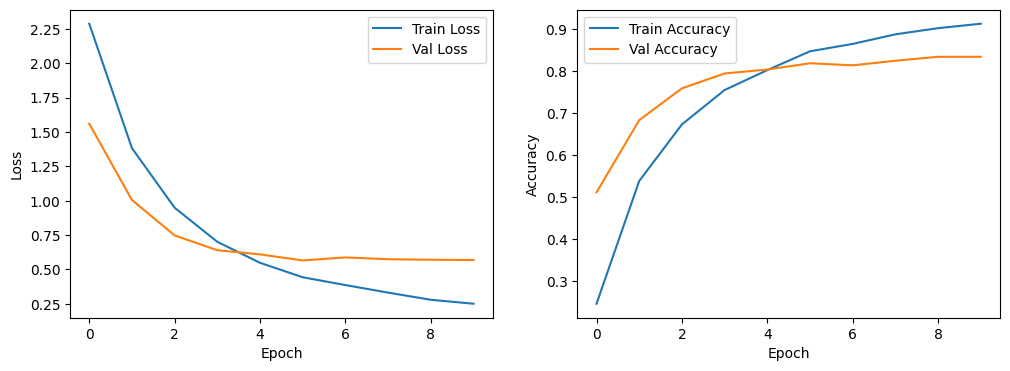

94/94 [==============================] - 0s 3ms/step - loss: 0.5589 - accuracy: 0.8313
Test Loss: 0.5589016079902649
Test Accuracy: 0.831333339214325


In [ ]:
# Graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

After adding dropout, the model achieved an accuracy of 83% on the test dataset.


# **The actual model - Convolutional Neural Network (CNN)**:

The CNN model consists of 2 convolutional layers with 32 and 64 filters, each using the ReLU activation function,followed by 2 max-pooling layers, and an output layer with the softmax activation function.


Epoch 1/20
141/141 [==============================] - 8s 13ms/step - loss: 1.6438 - accuracy: 0.4962 - val_loss: 1.0007 - val_accuracy: 0.6923
Epoch 2/20
141/141 [==============================] - 1s 11ms/step - loss: 0.7352 - accuracy: 0.7753 - val_loss: 0.6189 - val_accuracy: 0.8150
Epoch 3/20
141/141 [==============================] - 1s 10ms/step - loss: 0.4863 - accuracy: 0.8492 - val_loss: 0.5238 - val_accuracy: 0.8347
Epoch 4/20
141/141 [==============================] - 1s 9ms/step - loss: 0.3451 - accuracy: 0.8957 - val_loss: 0.3821 - val_accuracy: 0.8890
Epoch 5/20
141/141 [==============================] - 1s 8ms/step - loss: 0.2466 - accuracy: 0.9254 - val_loss: 0.3628 - val_accuracy: 0.8863
Epoch 6/20
141/141 [==============================] - 1s 9ms/step - loss: 0.1895 - accuracy: 0.9429 - val_loss: 0.3301 - val_accuracy: 0.9060
Epoch 7/20
141/141 [==============================] - 1s 9ms/step - loss: 0.1492 - accuracy: 0.9557 - val_loss: 0.3142 - val_accuracy: 0.9100
Epo

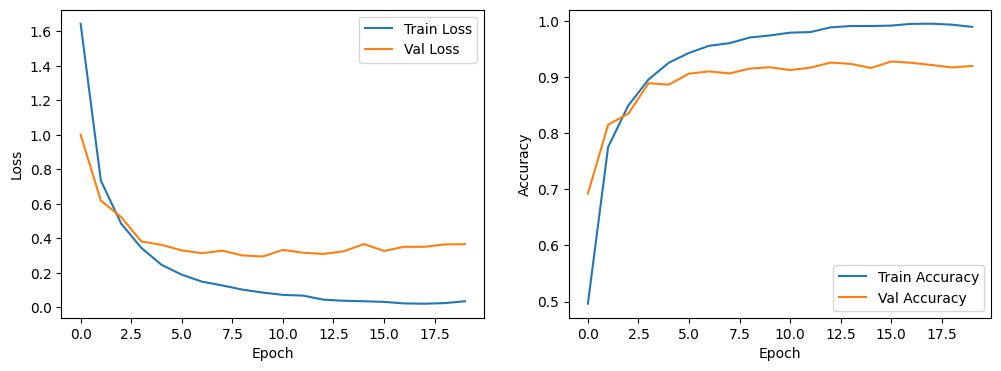

94/94 [==============================] - 1s 4ms/step - loss: 0.3894 - accuracy: 0.9250
Test Loss: 0.38944515585899353
Test Accuracy: 0.925000011920929


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.25)

# Plots showing the dependency of loss, validation loss, accuracy, and validation accuracy on each epoch.

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

The CNN model is performing well with an accuracy of 92.5% on the test dataset, 98% on the training dataset,and 92% on the validation dataset. The loss on the training and validation sets decreased with each epoch,starting at 1.6438 and 1.0007 in the first epoch and reaching 0.0356 and 0.3665 in the final epoch. The test set loss is 0.3894. It seems that the model is already effectively classifying, but I will attempt to further improve its performance by adding dropout


In [ ]:
# Model with dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

#model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.25)

Epoch 1/20
141/141 [==============================] - 5s 28ms/step - loss: 1.4886 - accuracy: 0.5512 - val_loss: 0.9319 - val_accuracy: 0.7377
Epoch 2/20
141/141 [==============================] - 3s 24ms/step - loss: 0.6818 - accuracy: 0.7866 - val_loss: 0.6785 - val_accuracy: 0.7973
Epoch 3/20
141/141 [==============================] - 3s 24ms/step - loss: 0.4610 - accuracy: 0.8546 - val_loss: 0.5481 - val_accuracy: 0.8383
Epoch 4/20
141/141 [==============================] - 3s 24ms/step - loss: 0.3238 - accuracy: 0.8994 - val_loss: 0.4705 - val_accuracy: 0.8687
Epoch 5/20
141/141 [==============================] - 4s 25ms/step - loss: 0.2407 - accuracy: 0.9234 - val_loss: 0.4411 - val_accuracy: 0.8727
Epoch 6/20
141/141 [==============================] - 3s 24ms/step - loss: 0.1691 - accuracy: 0.9506 - val_loss: 0.4400 - val_accuracy: 0.8777
Epoch 7/20
141/141 [==============================] - 3s 24ms/step - loss: 0.1328 - accuracy: 0.9584 - val_loss: 0.4226 - val_accuracy: 0.8847

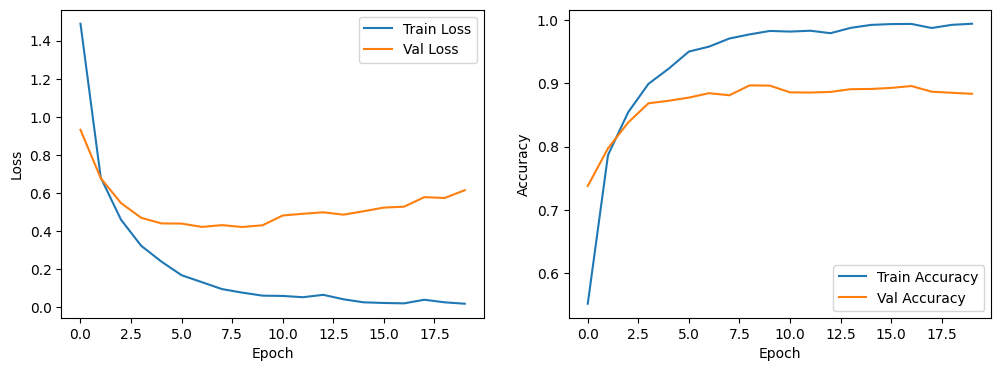

94/94 [==============================] - 0s 5ms/step - loss: 0.6119 - accuracy: 0.8843
Test Loss: 0.6118607521057129
Test Accuracy: 0.8843333125114441


In [ ]:
# Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

The performance didn't improve with dropout, and furthermore, the validation loss shows a slight increase while the training loss continues to decrease, indicating potential overfitting.

I will try adding an additional convolutional layer with 128 filters to the model.


In [ ]:
# Adding an additional convolutional layer with 128 filters
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

#model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.25)


Epoch 1/20
141/141 [==============================] - 9s 44ms/step - loss: 1.3648 - accuracy: 0.5858 - val_loss: 1.0329 - val_accuracy: 0.7837
Epoch 2/20
141/141 [==============================] - 5s 36ms/step - loss: 0.5230 - accuracy: 0.8387 - val_loss: 0.6456 - val_accuracy: 0.8493
Epoch 3/20
141/141 [==============================] - 5s 37ms/step - loss: 0.3313 - accuracy: 0.8937 - val_loss: 0.4394 - val_accuracy: 0.9047
Epoch 4/20
141/141 [==============================] - 5s 34ms/step - loss: 0.2192 - accuracy: 0.9298 - val_loss: 0.3737 - val_accuracy: 0.9217
Epoch 5/20
141/141 [==============================] - 5s 35ms/step - loss: 0.1644 - accuracy: 0.9450 - val_loss: 0.3276 - val_accuracy: 0.9140
Epoch 6/20
141/141 [==============================] - 5s 36ms/step - loss: 0.1485 - accuracy: 0.9534 - val_loss: 0.3134 - val_accuracy: 0.9200
Epoch 7/20
141/141 [==============================] - 4s 31ms/step - loss: 0.1235 - accuracy: 0.9560 - val_loss: 0.2821 - val_accuracy: 0.9237

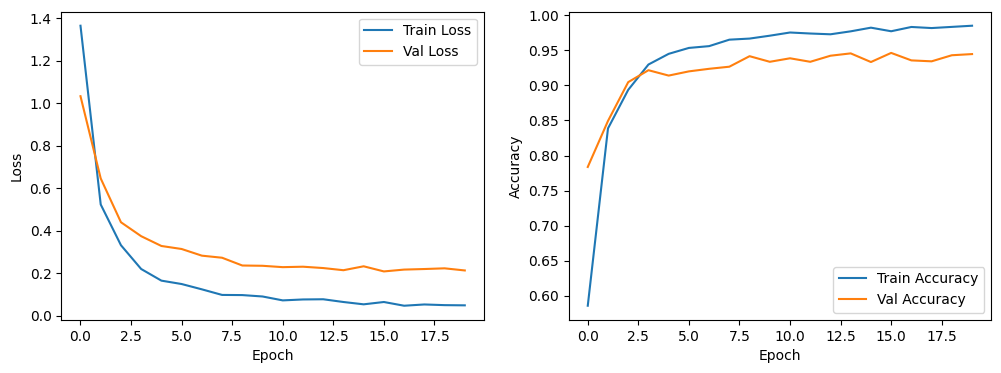

94/94 [==============================] - 1s 7ms/step - loss: 0.2265 - accuracy: 0.9427
Test Loss: 0.22645947337150574
Test Accuracy: 0.9426666498184204


In [ ]:
# Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

The results are looking promising, but I would like to see how they change when I increase the number of epochs to 30.


In [ ]:
# Model with 30 epochs
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

#model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.25)

Epoch 1/30
141/141 [==============================] - 6s 35ms/step - loss: 1.3268 - accuracy: 0.5896 - val_loss: 0.8972 - val_accuracy: 0.8117
Epoch 2/30
141/141 [==============================] - 5s 33ms/step - loss: 0.4800 - accuracy: 0.8524 - val_loss: 0.6111 - val_accuracy: 0.8630
Epoch 3/30
141/141 [==============================] - 4s 31ms/step - loss: 0.2833 - accuracy: 0.9076 - val_loss: 0.4362 - val_accuracy: 0.9033
Epoch 4/30
141/141 [==============================] - 5s 32ms/step - loss: 0.2015 - accuracy: 0.9344 - val_loss: 0.3828 - val_accuracy: 0.9057
Epoch 5/30
141/141 [==============================] - 5s 33ms/step - loss: 0.1564 - accuracy: 0.9497 - val_loss: 0.3122 - val_accuracy: 0.9250
Epoch 6/30
141/141 [==============================] - 5s 33ms/step - loss: 0.1252 - accuracy: 0.9563 - val_loss: 0.2738 - val_accuracy: 0.9290
Epoch 7/30
141/141 [==============================] - 5s 35ms/step - loss: 0.1012 - accuracy: 0.9669 - val_loss: 0.2436 - val_accuracy: 0.9383

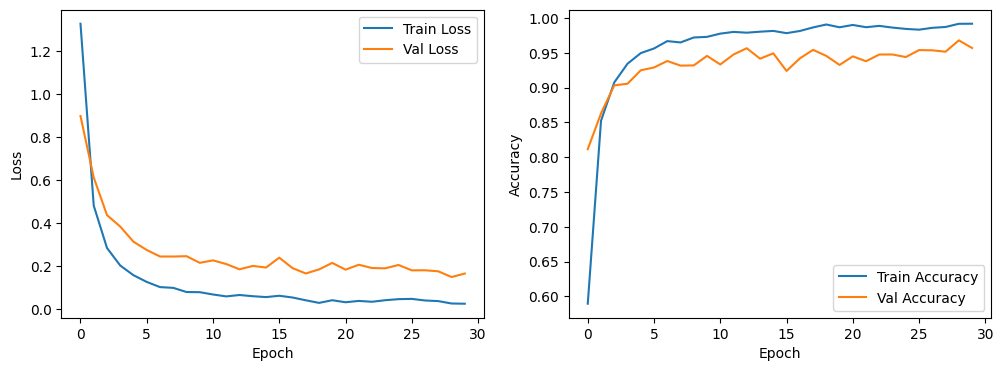

94/94 [==============================] - 1s 5ms/step - loss: 0.1836 - accuracy: 0.9550
Test Loss: 0.1836371123790741
Test Accuracy: 0.9549999833106995


In [ ]:
# plots
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

These are the best results achieved so far, and there is no sign of overfitting. The model has achieved high accuracy on both the training and validation data, and it has also demonstrated high accuracy on the test data, indicating its ability to perform well in classifying new data. I consider this the final result of the project. The results are significantly better than the baseline model's performance.
